In [6]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [17]:
creditcard_df = pd.read_csv('creditcard.csv')
creditcard_df.columns = [x.lower() for x in creditcard_df.columns]

X = creditcard_df.drop('class', axis=1)
y = creditcard_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [18]:
creditcard_df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
xg_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
def func(pct, allvals):
  absolute = int(round(pct/100.*np.sum(allvals)))
  return "{:.1f}%\n({:d} )".format(pct, absolute)

def drawPieChart(label, data, title):
  fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
  wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                    textprops=dict(color="w"))
  bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
  kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")
  for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(label[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
    plt.title(title)

<Axes: xlabel='time', ylabel='amount'>

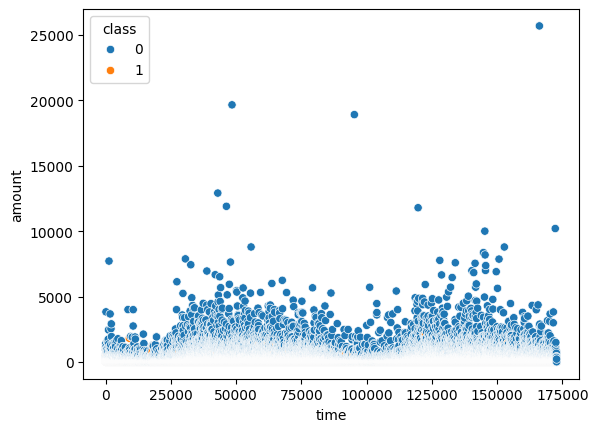

In [19]:
sns.scatterplot(data=creditcard_df, x='time', y='amount', hue='class')

Predicted fraud count:  130


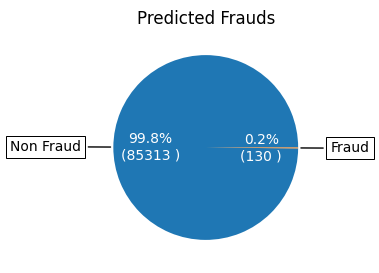

In [30]:
y_pred = xg_cl.predict(X_test)
print("Predicted fraud count: ", len(y_pred[y_pred == 1]))
buffer=pd.Series(y_pred)
drawPieChart(['Non Fraud', 'Fraud'], buffer.value_counts(), "Predicted Frauds")

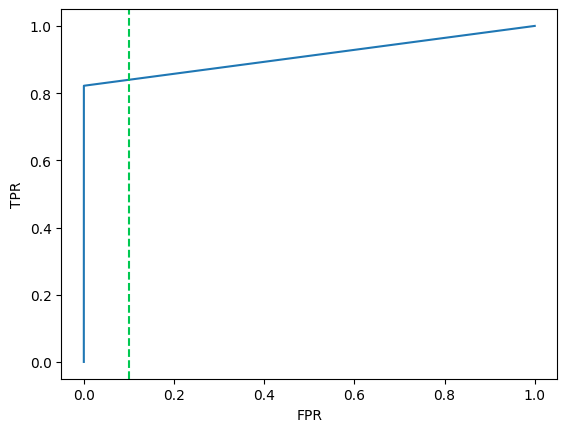

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Thresholds':thresholds})

_ = plt.figure()
plt.plot(roc.FPR, roc.TPR)
plt.axvline(0.1, color="#00C851", linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [25]:
dmatrix=xgb.DMatrix(data=creditcard_df.iloc[:,:-1],
                    label=creditcard_df['class'])
params={"objective":"binary:logistic","max_depth":4}
cv_results=xgb.cv(dtrain=dmatrix, params=params, nfold=4,
                  num_boost_round=10, metrics="error", as_pandas=True)
print("Accuracy: %f" %((1-cv_results["test-error-mean"].iloc[-1])))

Accuracy: 0.999484


In [27]:
cv_results=xgb.cv(dtrain=dmatrix, params=params, nfold=3,
                  num_boost_round=5, metrics="auc", as_pandas=True, seed=123)
print(cv_results)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.925346       0.001840       0.925144      0.003439
1        0.925377       0.001847       0.925179      0.003446
2        0.925393       0.001843       0.925200      0.003452
3        0.925398       0.001842       0.925214      0.003448
4        0.937752       0.013465       0.932460      0.009020


In [28]:
import pickle as pk
from google.colab import files

pk.dump(xg_cl, open('model.pkl', 'wb'))
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>